In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cclib

In [3]:
def extract_tddft_data_for_files(directory, files):
    tddft_data = {}
    for log_file in files:
        file_path = os.path.join(directory, log_file)
        try:
            data = cclib.io.ccread(file_path)
            if hasattr(data, 'etenergies') and hasattr(data, 'etoscs'):
                # Convert energies to eV
                converted_energies = [energy * 0.000123984 for energy in data.etenergies]
                oscillation_strengths = data.etoscs
                tddft_data[log_file] = (converted_energies, oscillation_strengths)
            else:
                print(f"No excited state data found in {log_file}.")
        except Exception as e:
            print(f"Error reading {log_file}: {e}")
    return tddft_data


# Directory and files
directory = "/Users/jennadraude/desktop/school/chem/research/PPV/plot"
#files = ["cisphenothiazine_monomer.log", "cisphenothiazine_2oligomer.log", "cisphenothiazine_3oligomer.log"]  
#files = ["transphenothiazine_monomer.log", "transphenothiazine_2oligomer.log", "transphenothiazine_3oligomer.log"] 
files = ["cisbuet_monomer.log", "cisbuet_2oligomer.log", "cisbuet_3oligomer.log"]
#files = ["transbuet_monomer.log", "transbuet_2oligomer.log", "transbuet_3oligomer.log"]

# Extract data
extracted_data = extract_tddft_data_for_files(directory, files)


In [4]:
def spectrum(E, osc, sigma, x):
    gE = []
    for Ei in x:
        tot = 0
        for Ej, os in zip(E, osc):
            tot += os * np.exp(-(((Ej - Ei) / sigma) ** 2))
        gE.append(tot)
    return gE

# Find the global maximum across all datasets
global_max = 0
for _, (energies, osc_strengths) in extracted_data.items():
    x = np.linspace(min(energies) - 0.5, max(energies) + 0.5, num=10000)
    gE_raw = spectrum(energies, osc_strengths, sigma=0.05, x=x)
    global_max = max(global_max, np.max(gE_raw))

def normalize_to_area(data):
    return data / np.trapz(data)



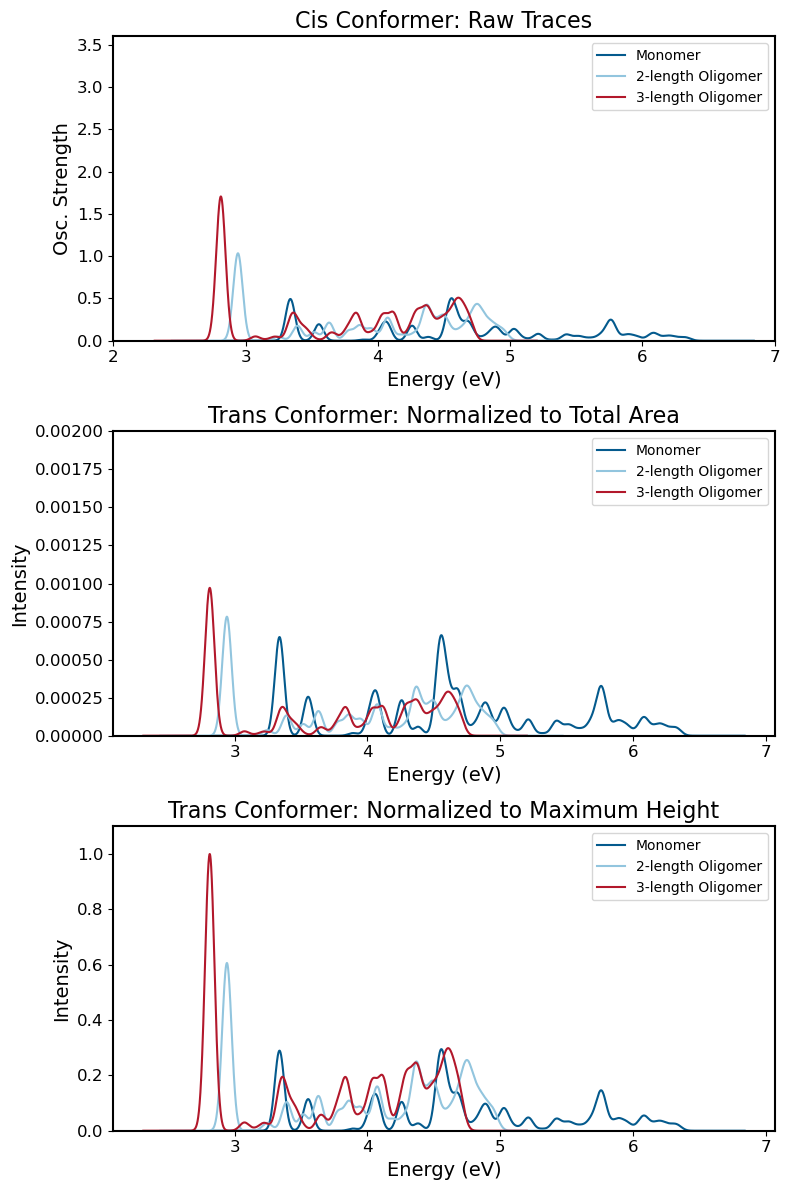

In [5]:
colors = ["#045a8d", "#92c5de", "#b2182b"]

# Create plots
fig, axes = plt.subplots(3, 1, figsize=(8, 12))
labels_names = ['Monomer', '2-length Oligomer', '3-length Oligomer']


# Raw traces
for idx, (file_name, (energies, osc_strengths)) in enumerate(extracted_data.items()):
    x = np.linspace(min(energies) - 0.5, max(energies) + 0.5, num=10000)
    gE_raw = spectrum(energies, osc_strengths, sigma=0.05, x=x)
    axes[0].plot(x, gE_raw, color=colors[idx], label=labels_names[idx])  
axes[0].set_ylabel("Osc. Strength", fontsize=14)
axes[0].set_ylim(0, 3.6)
axes[0].legend(fontsize=10)
axes[0].set_xlim(2,7)

# Normalized traces to total area
for idx, (file_name, (energies, osc_strengths)) in enumerate(extracted_data.items()):
    x = np.linspace(min(energies) - 0.5, max(energies) + 0.5, num=10000)
    gE_raw = spectrum(energies, osc_strengths, sigma=0.05, x=x)
    gE_norm_area = normalize_to_area(gE_raw)
    axes[1].plot(x, gE_norm_area, color=colors[idx], label=labels_names[idx])  
axes[1].set_ylabel("Intensity", fontsize=14)
axes[1].set_ylim(0, 0.002)
axes[1].legend(fontsize=10)

# Normalized traces to global max height
for idx, (file_name, (energies, osc_strengths)) in enumerate(extracted_data.items()):
    x = np.linspace(min(energies) - 0.5, max(energies) + 0.5, num=10000)
    gE_raw = spectrum(energies, osc_strengths, sigma=0.05, x=x)
    gE_norm_global_max = gE_raw / global_max
    axes[2].plot(x, gE_norm_global_max, color=colors[idx], label=labels_names[idx])  
axes[2].set_ylabel("Intensity", fontsize=14)
axes[2].set_ylim(0, 1.1)
axes[2].legend(fontsize=10)


# Plot formatting
#titles = ["Trans Conformer: Raw Traces", "Trans Conformer: Normalized to Total Area", "Trans Conformer: Normalized to Maximum Height"]
titles = ["Cis Conformer: Raw Traces", "Trans Conformer: Normalized to Total Area", "Trans Conformer: Normalized to Maximum Height"]
for ax, title in zip(axes, titles):
    ax.set_xlabel("Energy (eV)", fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.tick_params(labelsize=12)
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)

plt.tight_layout()
save_path = "/Users/jennadraude/desktop/spectrum_plot.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()